In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import statistics



## Helper functions!

In [27]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [28]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [29]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

In [30]:
X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,974,10,1,1,0,0
2,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,958,9,1,1,0,1
4,0,0,0,0,0,103,4,0,1,0,1


## Run model with ALL the added input variables

This is an optional step so we can see the base line model results. We can examine the p variables to determine which variables should be excluded.

In [31]:
# Preprocess the data
# 1. Separate the data into training and test data
# 2. Fit the scaling to the training data and apply to both the train and test data 

# Define columns to scale
columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X_new,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# 2. Scale
scaler = StandardScaler().fit(train[columns_to_scale]) 

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

train.head()


,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Shops,ATMs,Downtown,Weekday,Center,High
7214,71.451101,0.629417,0.807052,1,1,1,0.627193,0.830934,1,1,1,1
13522,64.949936,0.546223,0.397534,1,0,0,0.534761,0.286455,1,1,0,0
18479,70.265111,0.640364,0.192776,1,0,1,0.639356,0.014215,1,1,0,1
3366,70.693183,0.655689,0.602293,1,0,1,0.656382,0.558694,1,1,0,1
21645,16.757929,-1.540207,-1.445294,0,0,0,-1.508474,-1.346982,0,1,0,0


In [32]:
# 3. Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  5.54078924380115
Train MSE:  5.528847245434021


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.799e+05
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:28:19   Log-Likelihood:                -40021.
No. Observations:               17600   AIC:                         8.007e+04
Df Residuals:                   17588   BIC:                         8.016e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      89.2887      0.871    102.565      0.000      87.582      90.995
Shops_DT       42.1963      2.977     14.173      0.000      36.361      48.032
ATMs_DT        -0.1274      0.162     -0.785      0.432      -0.445       0.191
Weekday__DT    -1.8410      0.086    -21.525      0.000      -2.009      -1.673
Center_DT       5.2126      0.128     40.610      0.000       4.961       5.464
High_DT        -0.1242      0.085     -1.466      0.143      -0.290       0.042
Shops           7.6182      2.645      2.880      0.004       2.434      12.803
ATMs           -3.6402      0.116    -31.433      0.000      -3.867      -3.413
Downtown      -46.9708      1.236    -37.999      0.000     -49.394     -44.548
Weekday        -2.2179      0.071    -31.043      0.000      -2.358      -2.078
Center          3.5909      0.108     33.389      0.000       3.380       3.802
High            1.0376      0.071     14.607      0.000       0.898       1.177
==============================================================================
Omnibus:                    11022.141   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           213229.801
Skew:                           2.683   Prob(JB):                         0.00
Kurtosis:                      19.185   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: the MSE is already lower!

Looking at the p values, we should exclude variables `ATMs_DT` and `High_DT` from the model.


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [33]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 2048 iterations and 52.81 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=80064.89 with 11 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High

BIC=80141.20 with 9 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + ATMs + Downtown + Weekday + Center + High

test MSE: 5.54 has 10 parameters:
 Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

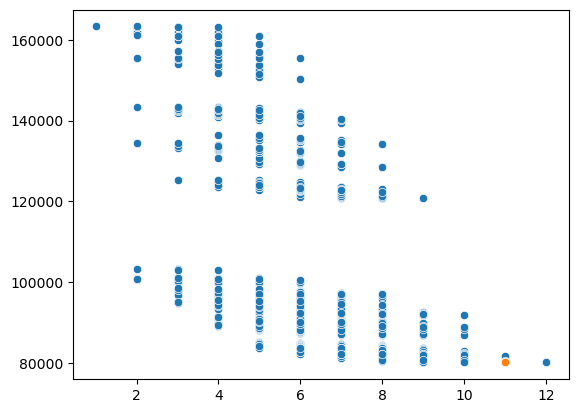

In [34]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

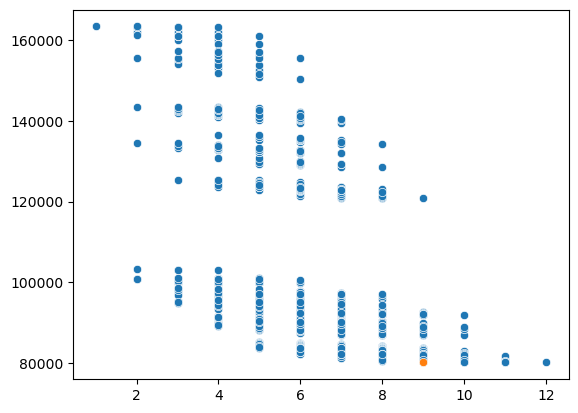

In [35]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

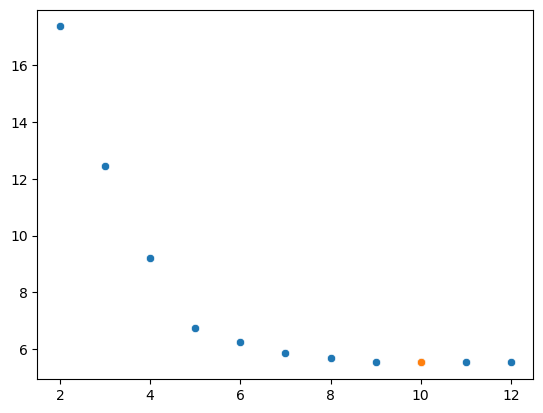

In [36]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

In [37]:
# 3. AIC Best Model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High"

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  5.539436110324526
Train MSE:  5.5297063672162485


In [38]:
# BIC Best Model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  5.541725579197457
Train MSE:  5.532288420642375


In [39]:
# Train MSE Best Model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + High_DT + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  5.540336098006683
Train MSE:  5.5290411111444175


Doing some manual cross validation checking to assess if doing cross validation is necessary

In [45]:
test_mse = []

for i in range(1,21):
    columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

    # 1. Separate
    X_train, X_test, y_train, y_test = train_test_split(
        X_new,              # Features
        y,                  # Target variable
        test_size=0.2,      # 20% for testing, 80% for training
        random_state=i      # Set for reproducibility
    )

    train = pd.concat([y_train,X_train], axis=1)
    test = pd.concat([y_test,X_test], axis=1)

    # 2. Scale
    scaler = StandardScaler().fit(train[columns_to_scale]) 

    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
    
    # AIC 
    formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High"

    # BIC
    #formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + ATMs + Downtown + Weekday + Center + High"
    model = ols(formula, data=train).fit()
    test_mse.append(comp_mse(model, test)) 

print("AIC: ")   
print(f"Mean : {statistics.mean(test_mse)}")
print(f"Max: {max(test_mse)}")
print(f"Min: {min(test_mse)}")

AIC: 
Mean : 5.588408004865069
Max: 6.151619207276769
Min: 5.0915533917555695


In [46]:
test_mse = []

for i in range(1,21):
    columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops','Shops_DT']

    # 1. Separate
    X_train, X_test, y_train, y_test = train_test_split(
        X_new,              # Features
        y,                  # Target variable
        test_size=0.2,      # 20% for testing, 80% for training
        random_state=i      # Set for reproducibility
    )

    train = pd.concat([y_train,X_train], axis=1)
    test = pd.concat([y_test,X_test], axis=1)

    # 2. Scale
    scaler = StandardScaler().fit(train[columns_to_scale]) 

    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
    
    # AIC 
    #formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops + ATMs + Downtown + Weekday + Center + High"

    # BIC
    formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + ATMs + Downtown + Weekday + Center + High"
    model = ols(formula, data=train).fit()
    test_mse.append(comp_mse(model, test)) 

print("BIC: ")
print(f"Mean : {statistics.mean(test_mse)}")
print(f"Max: {max(test_mse)}")
print(f"Min: {min(test_mse)}")

BIC: 
Mean : 5.590939972385697
Max: 6.154014003076197
Min: 5.093616448278345


From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 